In [10]:
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input  
from tensorflow.keras.preprocessing import image  
import math  
import matplotlib.pyplot as plt  
import numpy as np
from PIL import Image

In [11]:
TRAIN_DATA_DIR = 'Anime/train'  # Путь к каталогу с обучающими данными
VALIDATION_DATA_DIR = 'Anime/test'  # Путь к каталогу с данными для валидации
TRAIN_SAMPLES = 100  # Общее количество обучающих примеров
VALIDATION_SAMPLES = 400  # Общее количество примеров для валидации
NUM_CLASSES = 2  # Количество классов (в данном случае два класса: 'кошки' и 'собаки') НЕ МЕНЯТЬ
IMG_WIDTH, IMG_HEIGHT = 250, 250  # Размеры изображений (ширина и высота) НЕ МЕНЯТЬ
BATCH_SIZE = 2  # Размер пакета для обучения модели (количество образцов, обрабатываемых моделью за один шаг обучения) ХЗЗЗЗЗ

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                rotation_range=20,
                                width_shift_range=0.2, 
                                height_shift_range=0.2, 
                                zoom_range=0.2)    

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, target_size = (IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, shuffle=True, seed=12345, class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(VALIDATION_DATA_DIR, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, shuffle=False, seed=12345, class_mode='categorical')


Found 590 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


In [12]:

def model_maker():
    # Создание базовой модели MobileNet без верхнего слоя классификации,
    # указывается форма входных данных (ширина, высота, количество каналов)
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Замораживаем веса всех слоев базовой модели, чтобы они не обучались
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    # Определение входного тензора модели
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Пропуск данных через базовую модель
    custom_model = base_model(input)
    
    # Глобальное пулингование для уменьшения размерности признаков
    custom_model = GlobalAveragePooling2D()(custom_model)
    
    # Полносвязный слой с 16 нейронами и функцией активации ReLU
    custom_model = Dense(16, activation='relu')(custom_model)
    
    # Слой регуляризации для предотвращения переобучения
    custom_model = Dropout(0.25)(custom_model)
    
    # Выходной слой с NUM_CLASSES нейронами и функцией активации softmax для многоклассовой классификации
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    
    # Создание модели с заданными входом и выходом
    return Model(inputs=input, outputs=predictions)

In [13]:
model = model_maker()  # Создание модели нейронной сети с помощью функции model_maker()

model.compile(loss='categorical_crossentropy',  # Функция потерь - категориальная перекрестная энтропия
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Оптимизатор - Adam с коэффициентом скорости обучения 0.001
              metrics=['acc'])  # Метрика для оценки производительности модели - точность классификации

num_steps = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE)  # Вычисление количества шагов обучения

history = model.fit(train_generator,  # Обучение модели на обучающих данных
                steps_per_epoch=num_steps, 
                epochs=5,
                validation_data=validation_generator,  # Данные для валидации модели
                validation_steps=num_steps)  # Количество шагов валидации

C:\Users\Xleb\AppData\Local\Temp\ipykernel_16784\225212171.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - acc: 0.5291 - loss: 1.1491 - val_acc: 0.3300 - val_loss: 1.1247
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - acc: 0.5495 - loss: 0.7526 - val_acc: 0.3871 - val_loss: 0.8444
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - acc: 0.6139 - loss: 0.6174 - val_acc: 0.8000 - val_loss: 0.4417
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - acc: 0.7395 - loss: 0.5661 - val_acc: 0.5484 - val_loss: 0.7464
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - acc: 0.7463 - loss: 0.5106 - val_acc: 0.8400 - val_loss: 0.3904


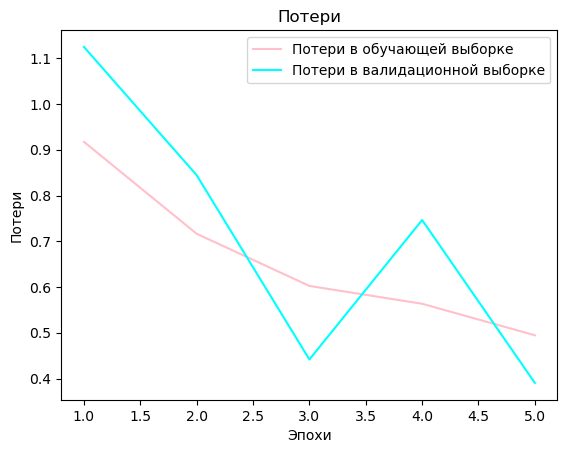

In [14]:
loss_function = history.history['loss']  # Получение значений функции потерь на обучающем наборе данных из истории обучения
val_loss_function = history.history['val_loss']  # Получение значений функции потерь на валидационном наборе данных из истории обучения
epochs = range(1, len(loss_function) + 1)  # Создание списка эпох для оси x

plt.title('Потери')  # Заголовок графика
plt.plot(epochs, loss_function, color='pink', label='Потери в обучающей выборке')  # График функции потерь на обучающем наборе
plt.plot(epochs, val_loss_function, color='cyan', label='Потери в валидационной выборке')  # График функции потерь на валидационном наборе
plt.xlabel('Эпохи')  # Подпись оси x
plt.ylabel('Потери')  # Подпись оси y
plt.legend()  # Добавление легенды
plt.show()  # Отображение графика

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


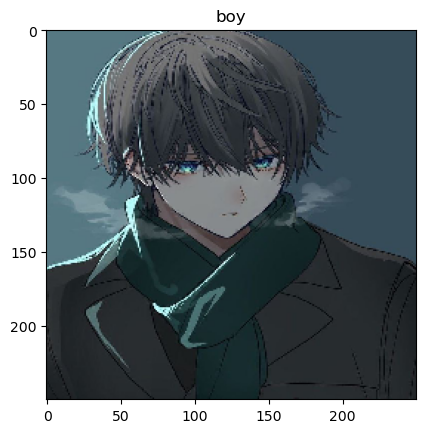

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


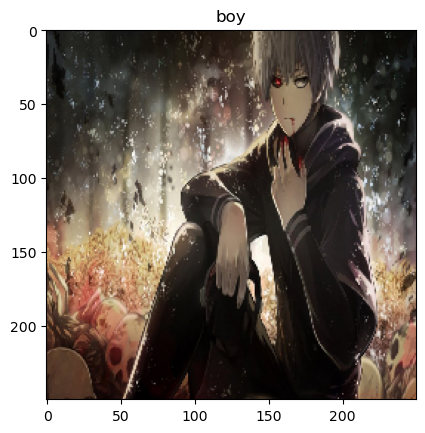

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


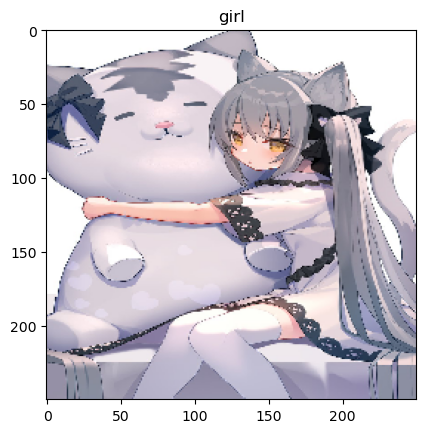

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


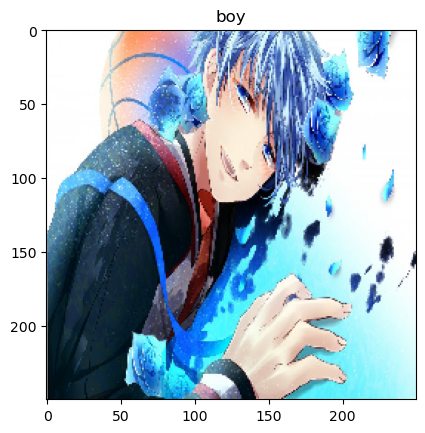

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


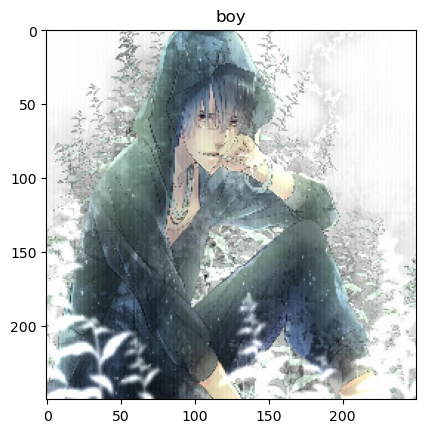

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


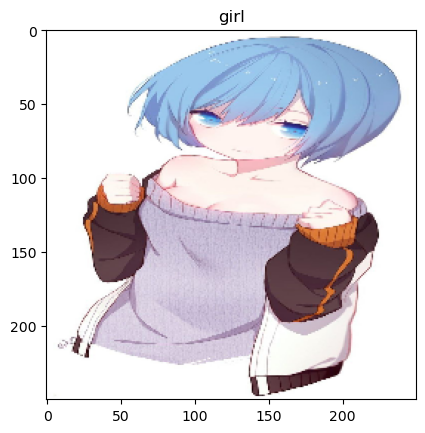

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


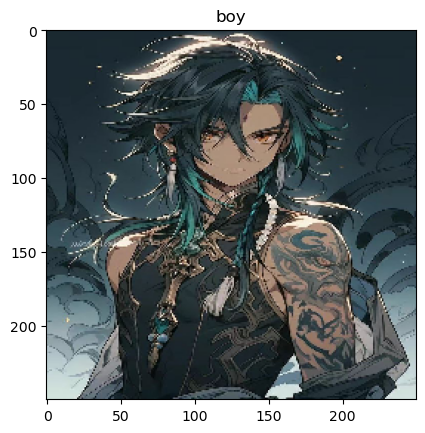

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


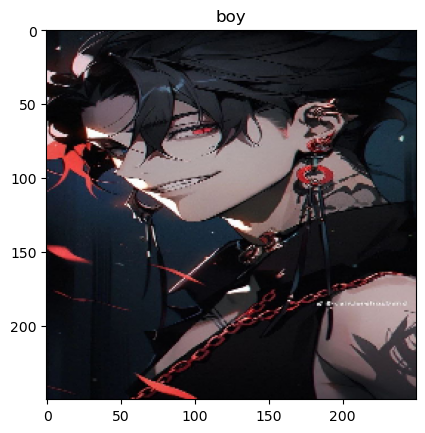

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


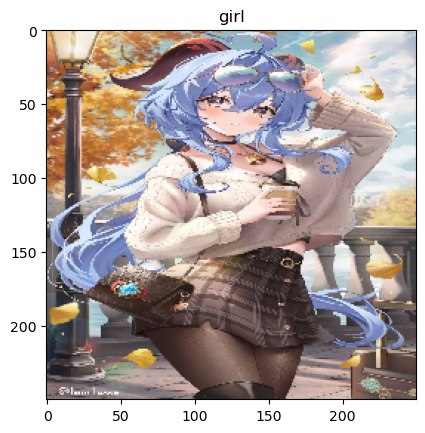

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


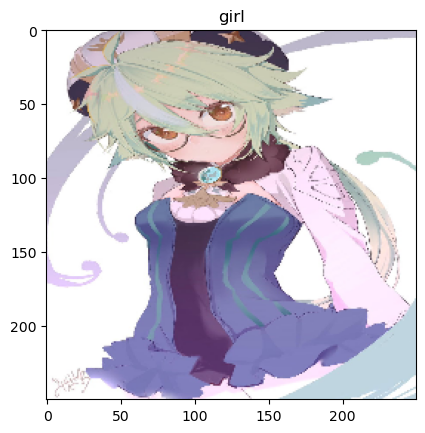

In [21]:
import os 
import random 
categ = ['boy', 'girl'] 
files = [] 
for root, dirs, filenames in os.walk('Anime/test/woman'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

for root, dirs, filenames in os.walk('Anime/test/man'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

for f in random.sample(files, 10):
    img_path = f 
    img = image.load_img(img_path, target_size=(250,250))  
    img_array = image.img_to_array(img)  # Преобразование изображения в массив numpy

    expanded_img_array = np.expand_dims(img_array, axis=0)  # Расширение массива изображения
    preprocessed_img = preprocess_input(expanded_img_array)  # Предварительная обработка изображения
    prediction = model.predict(preprocessed_img)  # Получение предсказания от модели
    
    plt.title(categ[np.argmax(prediction)])
    plt.imshow(img) 
    plt.show() 
